In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa
import functions_py.fates_nearest_gridcell as ngr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm


In [2]:
dark = cm.get_cmap('Dark2', 8)
colormap = dark(range(8))

In [3]:
pfts = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']


In [4]:
w = [  2,   2,   6, -10,  10,   6,  10, -18, -14,  -6,  10, -14,  -2,
        18,  14,  14, -18]
z = [ 25,  30, 355,  35, 285, 295, 275, 315, 295, 310, 295, 305, 280,
       100, 100,  75, 145]
lat_un = xr.DataArray(w, dims = ['location']).astype(int)
lon_un = xr.DataArray(z, dims = ['location']).astype(int)


In [5]:
# atkin - first ten years
fates_atkin ='/compyfs/need138/elm_runs/atkin_tveg_fix.Ec63cce2-F0a617d8.2023-01-19/run/lnd/hist/atkin_tveg_fix.Ec63cce2-F0a617d8.2023-01-19.elm.h0.sofar2000s.nc'
fates_atkin = xr.open_dataset(fates_atkin, decode_times=False)

# atkin init dbh - full run
fates_atkin_v2 = '/compyfs/need138/elm_runs/fixedbiogeog_nocomp_Atkin_dbh_initd4.Eb645be3-F3d56c69.2023-02-23/run/lnd/hist/fixedbiogeog_nocomp_Atkin_dbh_initd4.Eb645be3-F3d56c69.2023-02-23.elm.h0.sofar.nc'
fates_atkin_v2 = xr.open_dataset(fates_atkin_v2, decode_times=False)

n_lat = len(fates_atkin.variables['lat'])
n_lon = len(fates_atkin.variables['lon'])

nyears = int(len(fates_atkin_v2.variables['time'])/12)

time = fates_atkin.variables['time'] / 365.
time_v2 = fates_atkin_v2.variables['time']/365.

cohort_size_bins = fates_atkin.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

In [6]:
vegc_atkin = fates_atkin.FATES_VEGC
vegc_atkin = vegc_atkin.sel(lat=lat_un,lon=lon_un)

vegc_atkin_v2 = fates_atkin_v2.FATES_VEGC
vegc_atkin_v2 = vegc_atkin_v2.sel(lat=lat_un,lon=lon_un)


Text(0.02, 0.5, 'Veg C')

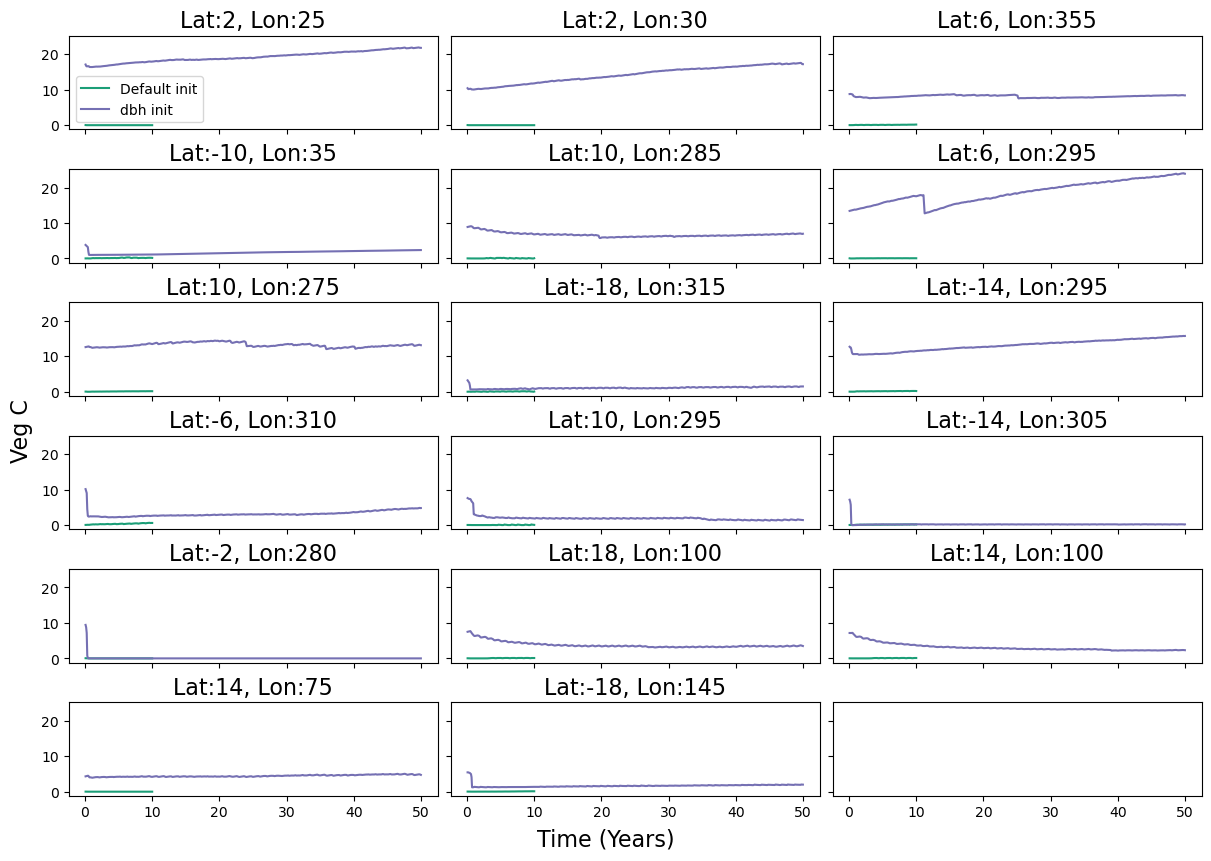

In [7]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time, vegc_atkin[:,i], label='Default init', color=colormap[0])
    axs[i].plot(time_v2, vegc_atkin_v2[:,i], label='dbh init', color=colormap[2])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'Veg C', fontsize=16)

Text(0.02, 0.5, 'Nplant')

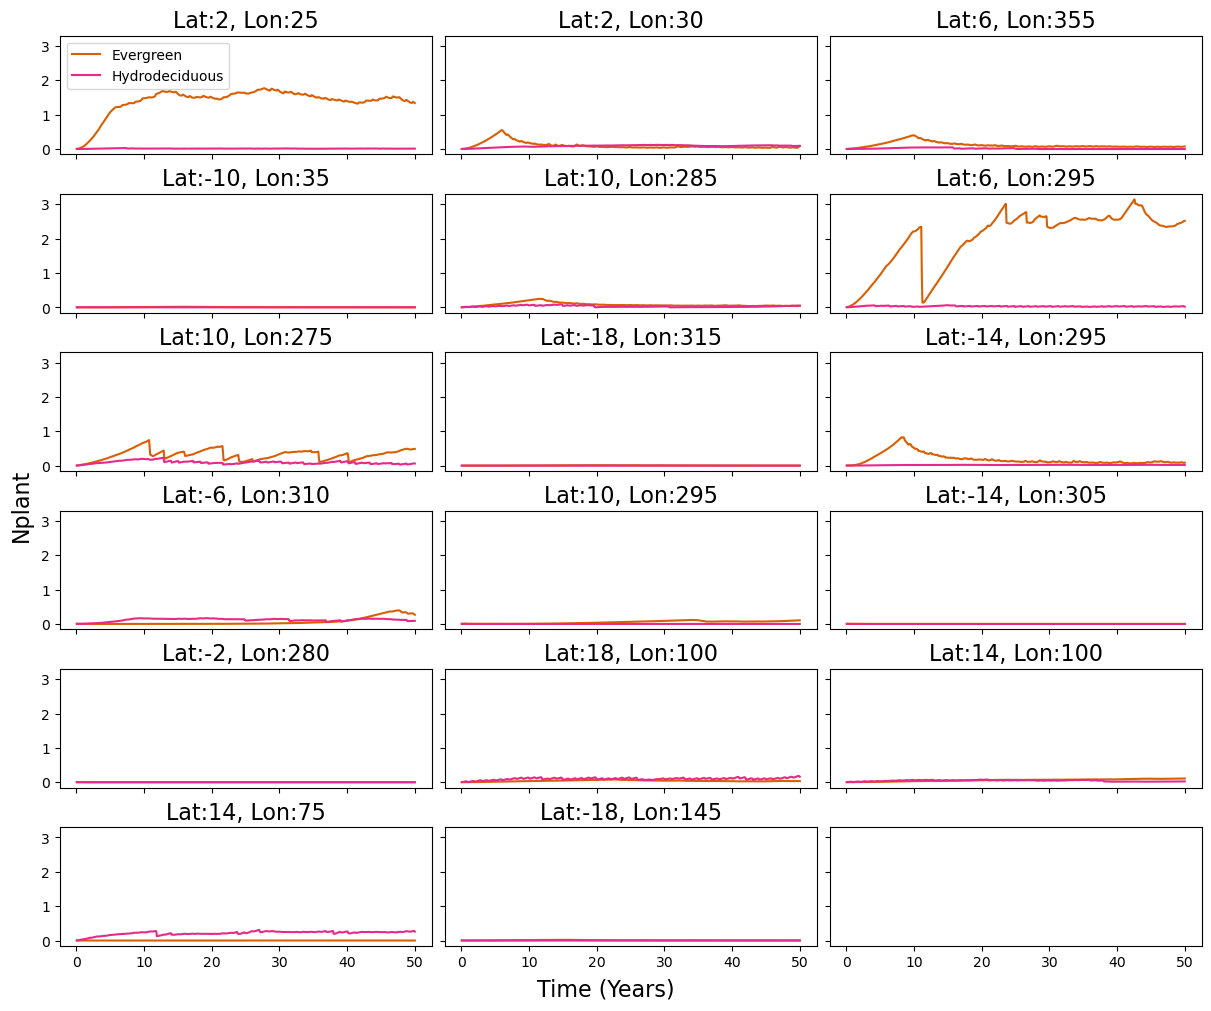

In [8]:
nplant_atkin = fates_atkin_v2.FATES_NPLANT_PF
nplant_atkin = nplant_atkin.sel(lat=lat_un,lon=lon_un)

nplant_atkin_pft1 = nplant_atkin.isel(fates_levpft=0)
nplant_atkin_pft5 = nplant_atkin.isel(fates_levpft=4)

fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,10), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time_v2, nplant_atkin_pft1[:,i], label='Evergreen', color=colormap[1])
    axs[i].plot(time_v2, nplant_atkin_pft5[:,i], label='Hydrodeciduous', color=colormap[3])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'Nplant', fontsize=16)


### Storage carbon through time - hydro PFTs

In [9]:
store_sz_by_pft = fa.scpf_to_scls_by_pft(fates_atkin_v2.FATES_STOREC_SZPF, fates_atkin_v2)
store_ev = store_sz_by_pft.isel(fates_levpft=0) # pft 1 
store_ev = store_ev.sum(dim='fates_levscls') # sum over sizes
store_ev = store_ev.sel(lat=lat_un,lon=lon_un)
store_hy = store_sz_by_pft.isel(fates_levpft=4) # pft 1 
store_hy = store_hy.sum(dim='fates_levscls') # sum over sizes
store_hy = store_hy.sel(lat=lat_un,lon=lon_un)
print(store_ev.shape)

(600, 17)


In [10]:
leaf_sz_by_pft = fa.scpf_to_scls_by_pft(fates_atkin_v2.FATES_LEAFC_SZPF, fates_atkin_v2)
leaf_ev = leaf_sz_by_pft.isel(fates_levpft=0) # pft 1 
leaf_ev = leaf_ev.sum(dim='fates_levscls') # sum over sizes
leaf_ev = leaf_ev.sel(lat=lat_un,lon=lon_un)
leaf_hy = leaf_sz_by_pft.isel(fates_levpft=4) # pft 1 
leaf_hy = leaf_hy.sum(dim='fates_levscls') # sum over sizes
leaf_hy = leaf_hy.sel(lat=lat_un,lon=lon_un)
print(leaf_ev.shape)

(600, 17)


### leaf and storage carbon 

Text(0.02, 0.5, 'C kg m-2 - pft 1')

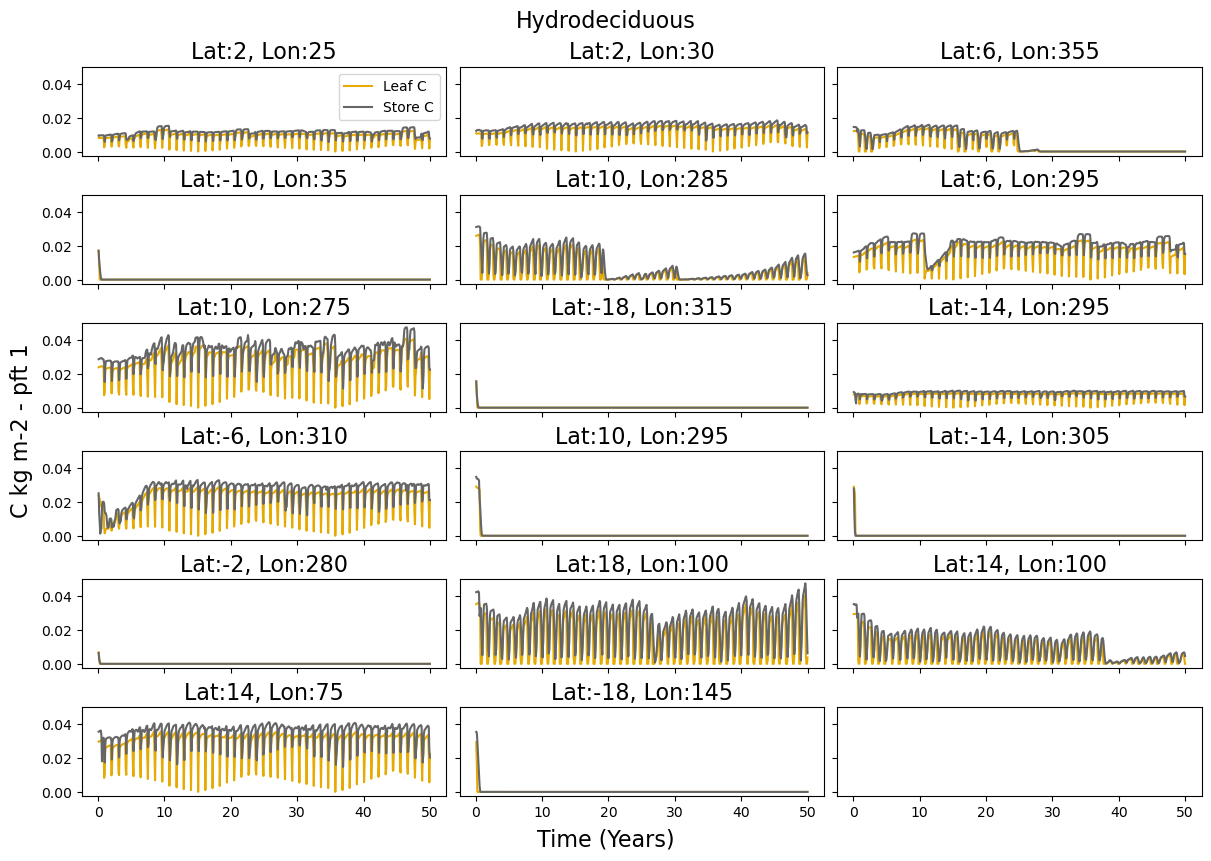

In [11]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time_v2, leaf_hy[:,i], label='Leaf C', color=colormap[5])
    axs[i].plot(time_v2, store_hy[:,i], label='Store C', color=colormap[7])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
fig.suptitle('Hydrodeciduous', fontsize=16)    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'C kg m-2 - pft 1', fontsize=16)

Text(0.02, 0.5, 'C kg m-2 - pft 1')

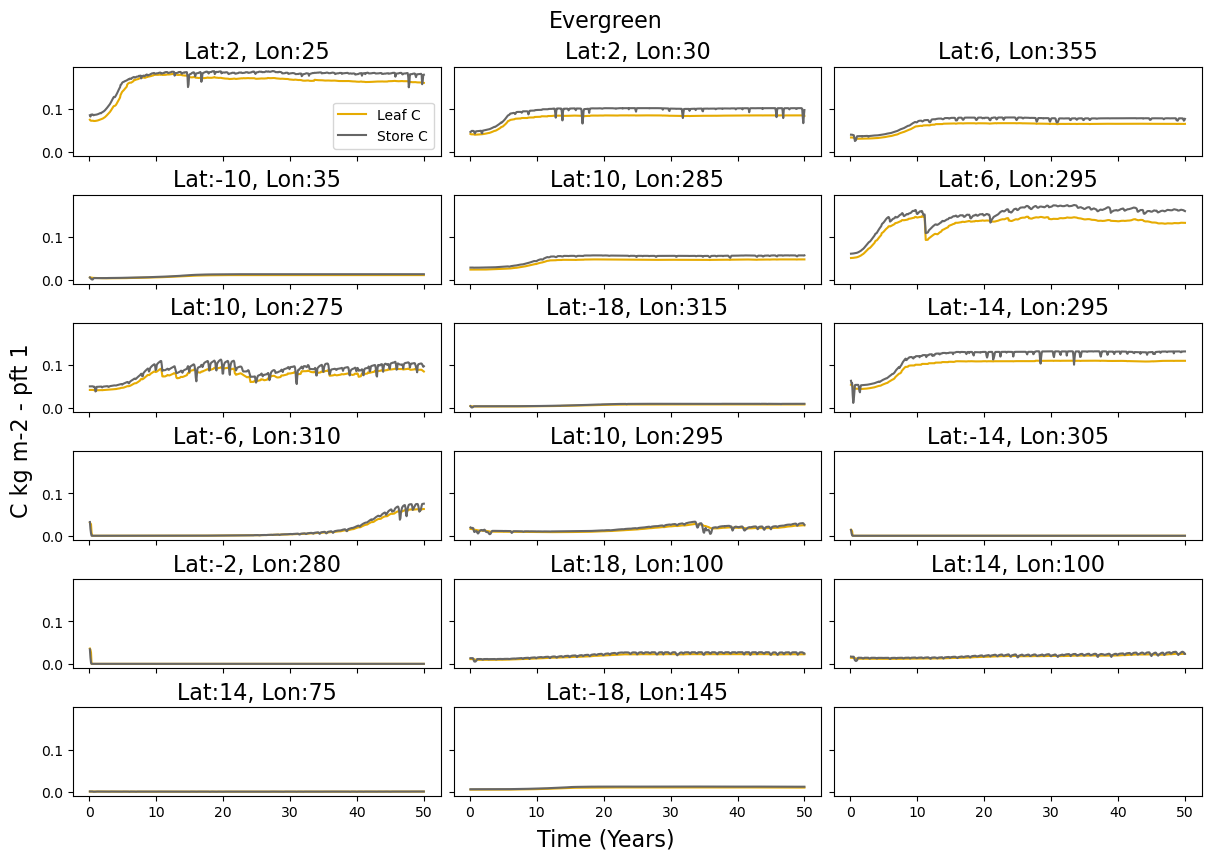

In [12]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time_v2, leaf_ev[:,i], label='Leaf C', color=colormap[5])
    axs[i].plot(time_v2, store_ev[:,i], label='Store C', color=colormap[7])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
fig.suptitle('Evergreen', fontsize=16)    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'C kg m-2 - pft 1', fontsize=16)

In [13]:
sapw_sz_by_pft = fa.scpf_to_scls_by_pft(fates_atkin_v2.FATES_SAPWOODC_SZPF, fates_atkin_v2)
sapw_ev = sapw_sz_by_pft.isel(fates_levpft=0) # pft 1 
sapw_ev = sapw_ev.sum(dim='fates_levscls') # sum over sizes
sapw_ev = sapw_ev.sel(lat=lat_un,lon=lon_un)
sapw_hy = sapw_sz_by_pft.isel(fates_levpft=4) # pft 1 
sapw_hy = sapw_hy.sum(dim='fates_levscls') # sum over sizes
sapw_hy = sapw_hy.sel(lat=lat_un,lon=lon_un)
print(sapw_ev.shape)

(600, 17)


Text(0.02, 0.5, 'Sapwood C kg m-2 - pft 1')

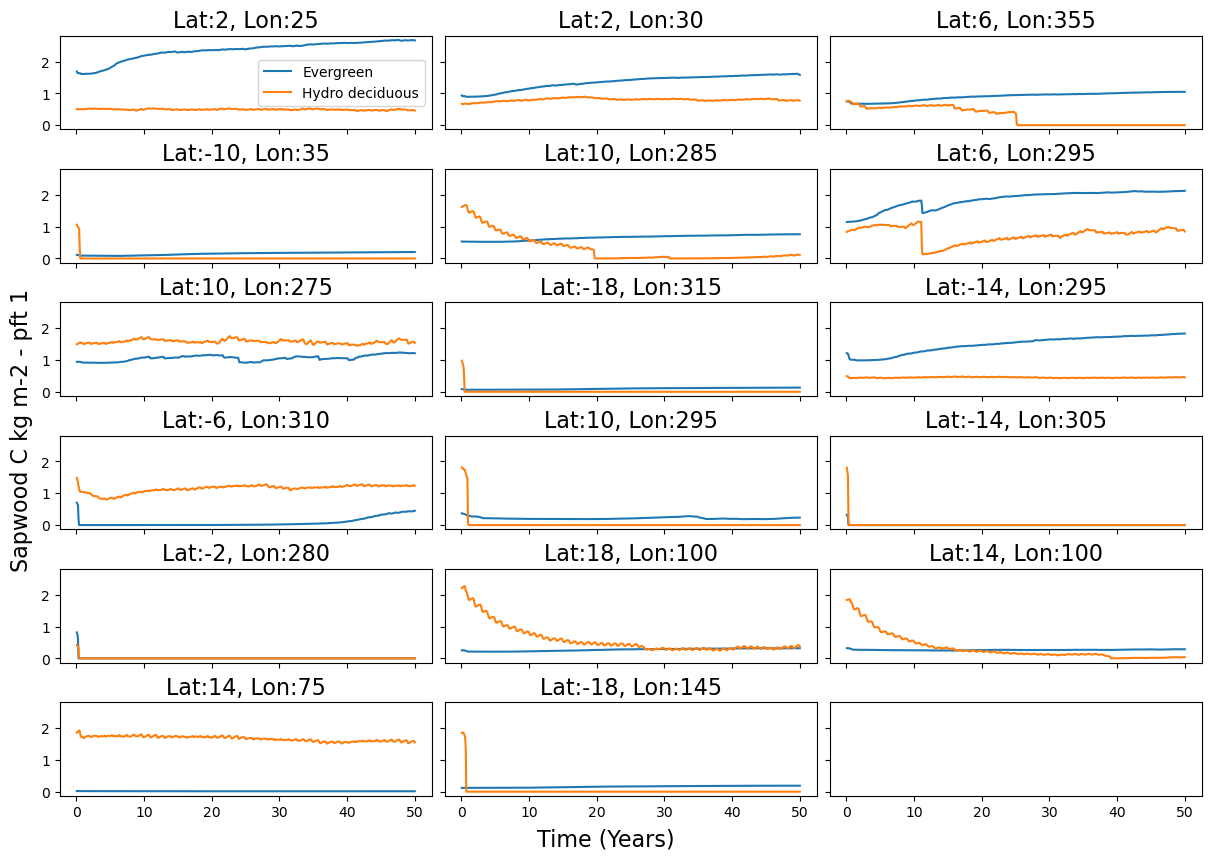

In [14]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(time_v2, sapw_ev[:,i], label='Evergreen')
    axs[i].plot(time_v2, sapw_hy[:,i], label='Hydro deciduous')
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'Time (Years)', fontsize=16)
fig.supylabel(r'Sapwood C kg m-2 - pft 1', fontsize=16)

### Size distribution first time step

In [15]:
nplant_sz_by_pft = fa.scpf_to_scls_by_pft(fates_atkin_v2.FATES_NPLANT_SZPF, fates_atkin_v2)
nplant_ev = nplant_sz_by_pft.isel(fates_levpft=0) # pft 1 
nplant_ev = nplant_ev.isel(time=0)
nplant_ev = nplant_ev.sel(lat=lat_un,lon=lon_un)
nplant_hy = nplant_sz_by_pft.isel(fates_levpft=4) # pft 1 
nplant_hy = nplant_hy.isel(time=0)
nplant_hy = nplant_hy.sel(lat=lat_un,lon=lon_un)
print(nplant_ev.shape)

(17, 11)


Text(0.02, 0.5, 'Nplant ')

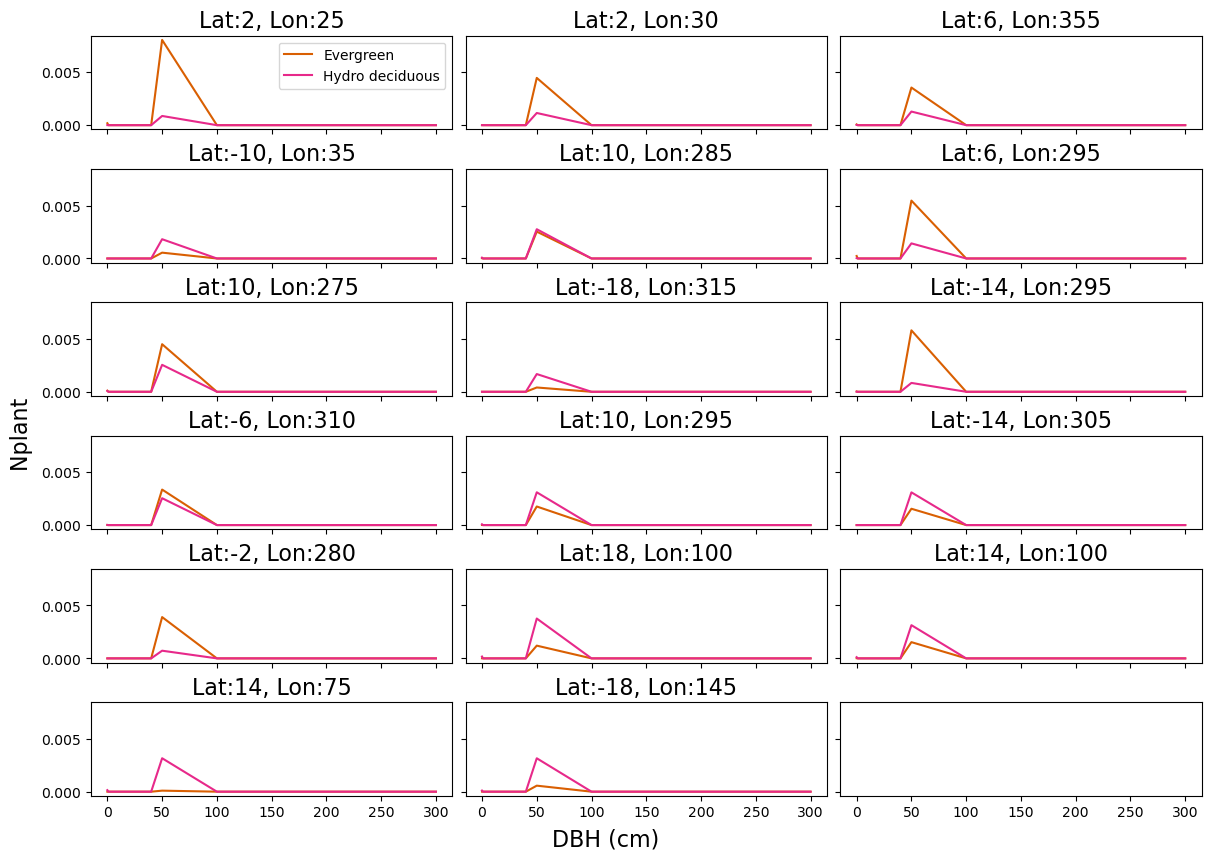

In [16]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(cohort_size_bins, nplant_ev[i,:], label='Evergreen', color=colormap[1])
    axs[i].plot(cohort_size_bins, nplant_hy[i,:], label='Hydro deciduous', color=colormap[3])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'DBH (cm)', fontsize=16)
fig.supylabel(r'Nplant ', fontsize=16)

### size distribution after 6 months

In [17]:
nplant_sz_by_pft = fa.scpf_to_scls_by_pft(fates_atkin_v2.FATES_NPLANT_SZPF, fates_atkin_v2)
nplant_ev = nplant_sz_by_pft.isel(fates_levpft=0) # pft 1 
nplant_ev = nplant_ev.isel(time=7)
nplant_ev = nplant_ev.sel(lat=lat_un,lon=lon_un)
nplant_hy = nplant_sz_by_pft.isel(fates_levpft=4) # pft 1 
nplant_hy = nplant_hy.isel(time=7)
nplant_hy = nplant_hy.sel(lat=lat_un,lon=lon_un)
print(nplant_ev.shape)

(17, 11)


Text(0.02, 0.5, 'Nplant ')

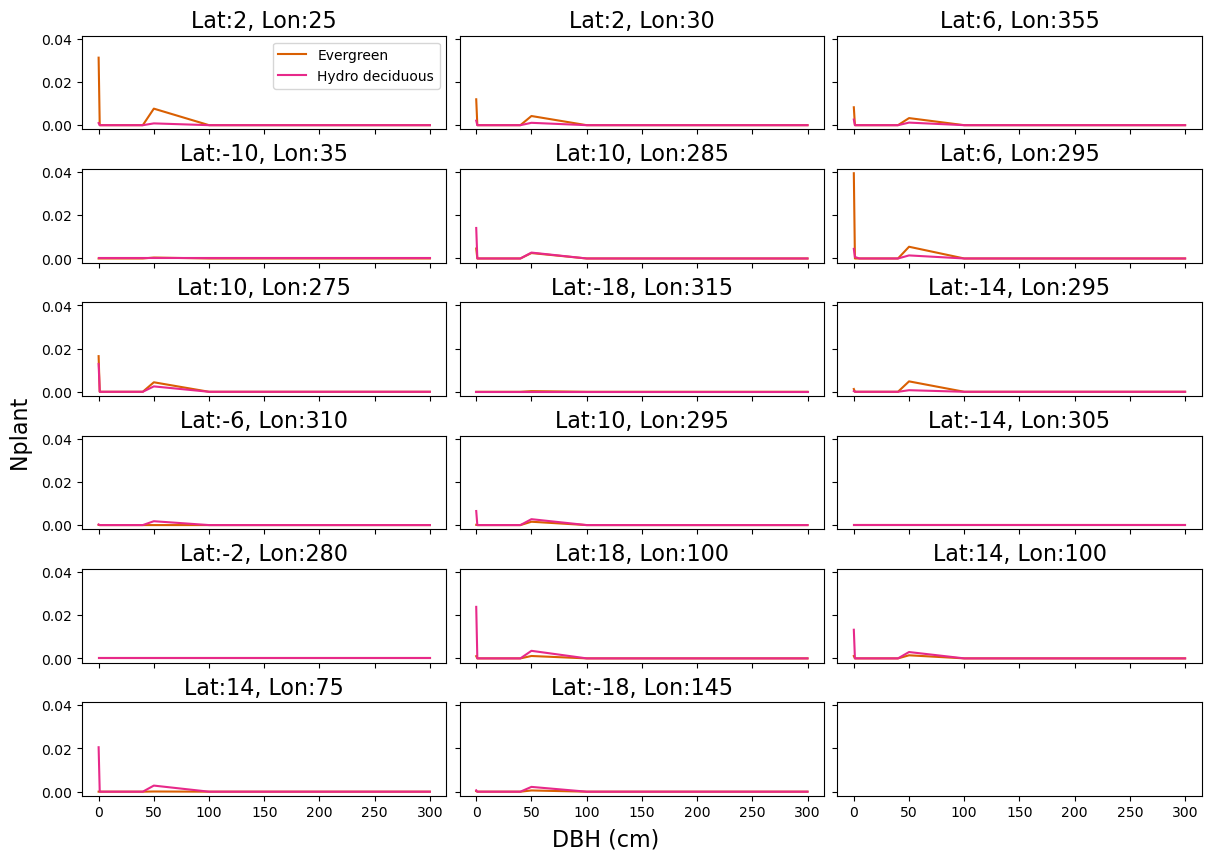

In [18]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        figsize=(12,8.5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,17):
    axs[i].plot(cohort_size_bins, nplant_ev[i,:], label='Evergreen', color=colormap[1])
    axs[i].plot(cohort_size_bins, nplant_hy[i,:], label='Hydro deciduous', color=colormap[3])
    axs[i].set_title(r'Lat:{0}, Lon:{1}'.format(w[i],z[i]), fontsize = 16)
    if i == 0 :
        axs[i].legend()
    
    
fig.supxlabel(r'DBH (cm)', fontsize=16)
fig.supylabel(r'Nplant ', fontsize=16)

### Global veg c 1 year in 

''

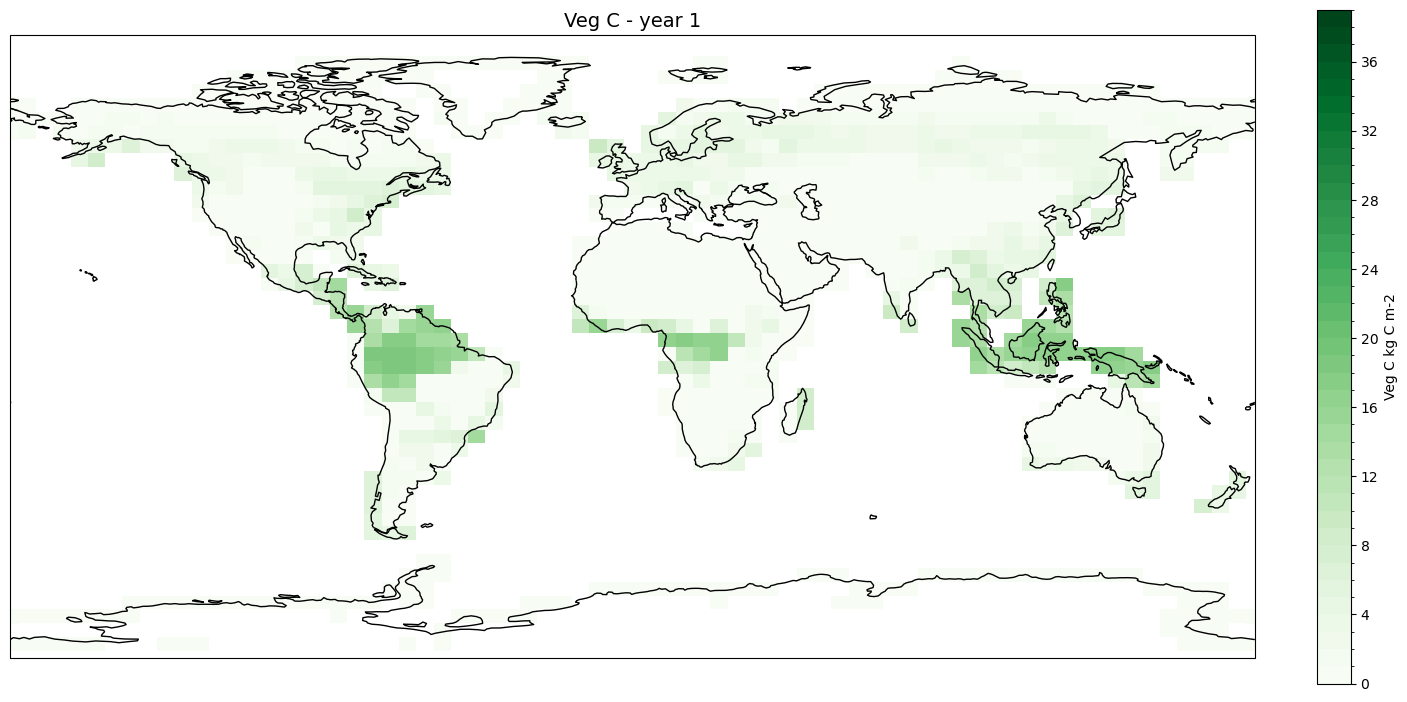

In [19]:
vegc_atkin_v2 = fates_atkin_v2.FATES_VEGC
vegc_atkin_v2 = vegc_atkin_v2.isel(time=slice(12,24)).mean(dim='time') 

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), constrained_layout=True)


clevs = np.arange(0.,40,1)
vegc_atkin_v2.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "Veg C kg C m-2"}, ax=axs)
axs.coastlines()
axs.set_title('Veg C - year 1', fontsize=14)

;

''

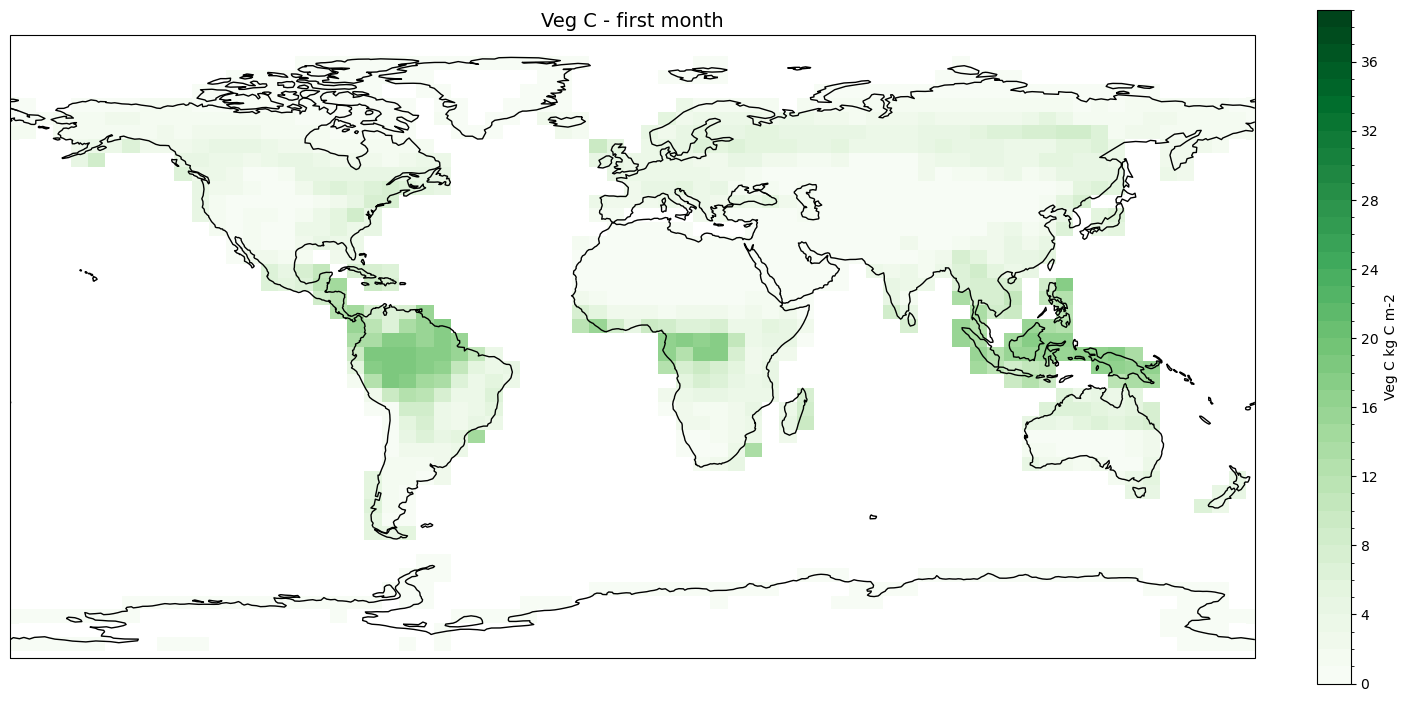

In [20]:
vegc_atkin_v2 = fates_atkin_v2.FATES_VEGC
vegc_atkin_v2 = vegc_atkin_v2.isel(time=slice(0,1)).mean(dim='time') 

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), constrained_layout=True)


clevs = np.arange(0.,40,1)
vegc_atkin_v2.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "Veg C kg C m-2"}, ax=axs)
axs.coastlines()
axs.set_title('Veg C - first month', fontsize=14)

;

In [21]:
print(len(time_v2))

600


### year 50 

''

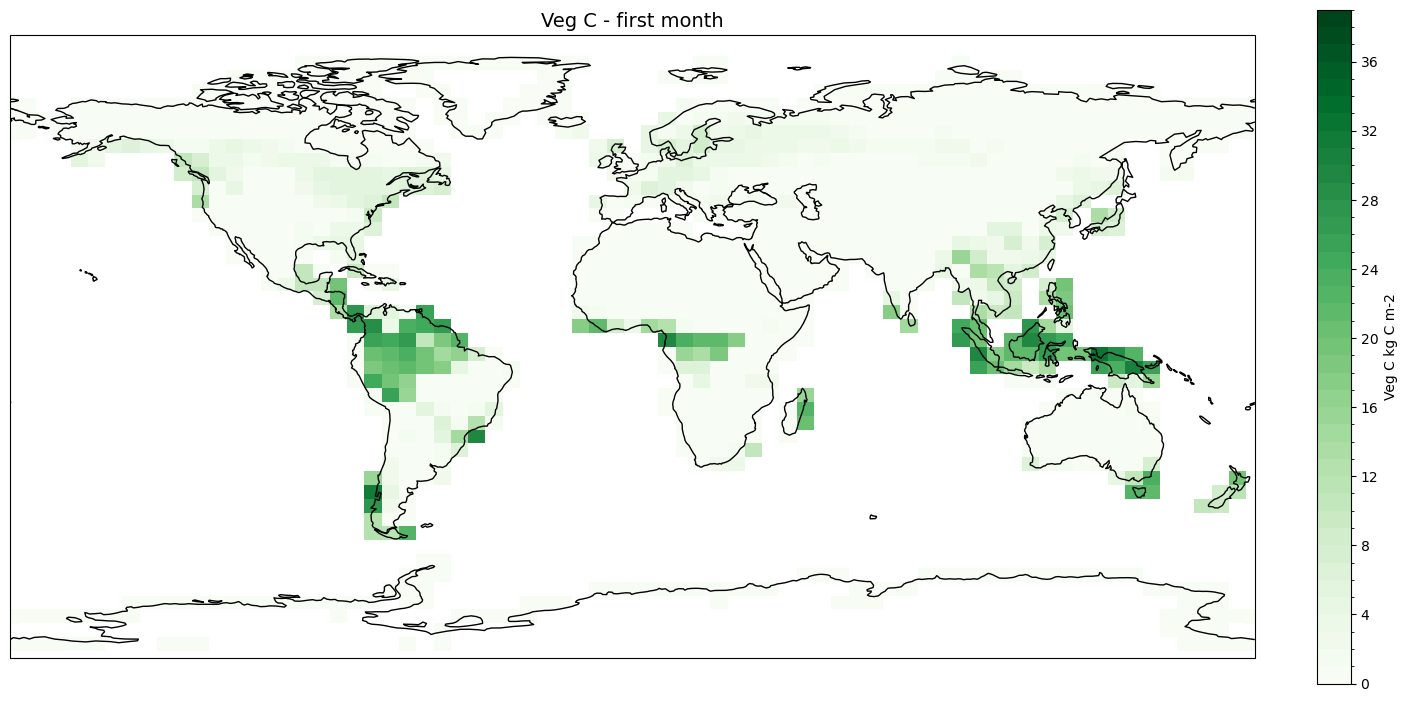

In [22]:
vegc_atkin_v2 = fates_atkin_v2.FATES_VEGC
vegc_atkin_v2 = vegc_atkin_v2.isel(time=slice(588,600)).mean(dim='time') 

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,7), constrained_layout=True)


clevs = np.arange(0.,40,1)
vegc_atkin_v2.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         cbar_kwargs={"label": "Veg C kg C m-2"}, ax=axs)
axs.coastlines()
axs.set_title('Veg C - first month', fontsize=14)

;